<a href="https://colab.research.google.com/github/Lutris98/21_1Q/blob/master/2.Santander/Santander_Upgrade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.EDA

In [395]:
import pandas as pd 
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV #the ones that could be written with simpler API
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score #auc means area under curve #asymmetric targetset makes auc score more valid

In [396]:
from google.colab import drive
drive.mount('/content/gdrive')
santander_df=pd.read_csv('/content/gdrive/MyDrive/Dataset/santander_train.csv')
test_df=pd.read_csv('/content/gdrive/MyDrive/Dataset/santander_test.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [397]:
df=pd.concat([santander_df,test_df],axis=0,ignore_index=True) #if not, df[5] will have double values 

##1) Basic statistics

In [398]:
df.info() #all in numerical forms

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151838 entries, 0 to 151837
Columns: 371 entries, ID to TARGET
dtypes: float64(116), int64(255)
memory usage: 429.8 MB


In [399]:
df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,...,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var13_medio_hace2,saldo_medio_var13_medio_hace3,saldo_medio_var13_medio_ult1,saldo_medio_var13_medio_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,151838.000000,151838.000000,151838.000000,151838.000000,151838.000000,151838.000000,151838.000000,151838.000000,151838.000000,151838.000000,151838.000000,151838.000000,151838.000000,151838.000000,151838.000000,151838.00000,151838.000000,151838.000000,151838.000000,151838.000000,151838.000000,151838.000000,151838.0,151838.0,151838.000000,151838.000000,151838.000000,151838.000000,151838.000000,151838.000000,151838.000000,151838.000000,151838.000000,151838.000000,151838.000000,151838.000000,151838.000000,151838.000000,151838.000000,151838.000000,...,151838.000000,151838.000000,151838.000000,151838.000000,151838.000000,151838.000000,1.518380e+05,1.518380e+05,1.518380e+05,1.518380e+05,151838.00000,151838.000000,151838.000000,151838.000000,1.518380e+05,151838.000000,1.518380e+05,1.518380e+05,151838.000000,151838.0,151838.000000,151838.000000,1.518380e+05,1.518380e+05,1.518380e+05,1.518380e+05,151838.000000,151838.000000,151838.000000,151838.000000,151838.000000,151838.000000,151838.000000,151838.000000,151838.000000,151838.000000,151838.000000,151838.000000,1.518380e+05,76020.000000
mean,75919.500000,-1551.539391,33.175898,84.688322,73.336683,121.330641,4.068145,7.068982,0.441757,0.619828,3.397988,69.268538,114.261659,67.823070,112.097599,137.22871,68.264828,112.717427,140.626698,5.197786,0.011782,0.003840,0.0,0.0,0.957514,0.663753,0.000099,0.000026,0.033259,0.029242,0.068066,0.045410,0.052727,0.043211,0.041814,0.010465,0.010287,0.000046,0.000046,0.051364,...,1067.075779,1054.428054,64.524891,9.433630,121.408072,107.419659,4.178141e+03,6.591445e+02,5.881090e+03,4.572940e+03,3610.34104,528.691117,4880.829788,3863.909609,7.939402e+02,169.371975,9.719136e+02,7.611156e+02,0.187225,0.0,0.865113,0.526170,6.378418e+01,2.135409e+01,9.432871e+01,7.849367e+01,0.175941,0.000956,0.224562,0.173630,10.184196,1.346302,14.839290,10.726624,47.530234,6.625190,85.986327,63.550096,1.173110e+05,0.039569
std,43831.999424,39394.010507,12.944275,1655.242347,351.967351,577.094428,115.015926,201.304542,32.359675,39.528498,113.423724,325.122860,526.270722,524.542862,845.803747,697.76556,528.480378,850.450440,715.321617,400.478394,0.107905,0.061846,0.0,0.0,0.201696,0.472426,0.009939,0.005133,0.179313,0.168484,0.251860,0.208203,0.223489,0.203331,0.200165,0.101763,0.100904,0.006790,0.006790,0.220740,...,9701.488869,8164.239360,1715.668251,514.772266,2222.832472,1876.62146

#2.Preprocessing

##1) Imputation

In [400]:
for var in df.columns:
  if df[var].min()==-999999 or df[var].min()==-99999 or df[var].min()==-9999 or df[var].min()==-999 or df[var].min()==-99 or df[var].min()==-9:
    print(var)

var3


In [401]:
df['var3'].value_counts()

 2         148127
 8            254
-999999       236
 9            218
 3            215
            ...  
 206            1
 210            1
 83             1
 211            1
 212            1
Name: var3, Length: 231, dtype: int64

In [402]:
df['var3'].loc[df['var3']==-999999]=df['var3'].median()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


##3) Discretization 

In [403]:
id_df=pd.DataFrame(df,columns=['ID']) 
target_df=pd.DataFrame(df,columns=['TARGET']) 
target_df.dropna(inplace=True)
df.drop(['ID','TARGET'],axis=1,inplace=True)

In [404]:
df.nunique().sort_values()

num_reemb_var33_hace3             1
saldo_var46                       1
saldo_var41                       1
ind_var41                         1
num_trasp_var33_out_hace3         1
                              ...  
saldo_medio_var5_ult1         25650
saldo_var42                   28458
saldo_medio_var5_ult3         29322
saldo_var30                   30654
var38                        109982
Length: 369, dtype: int64

In [405]:
for var in df.columns:
  if df[var].nunique()==1:
    df.drop(var,axis=1,inplace=True)

In [406]:
from sklearn.preprocessing import KBinsDiscretizer
for var in df.columns:
   discretizer=KBinsDiscretizer(n_bins=10,encode='ordinal',strategy='uniform') #prefer width if bin_width gets so small due to dispropotionate distribution
   disc=discretizer.fit_transform(df[var].values.reshape(-1,1))
   df[var]=pd.Series(disc.reshape(-1))

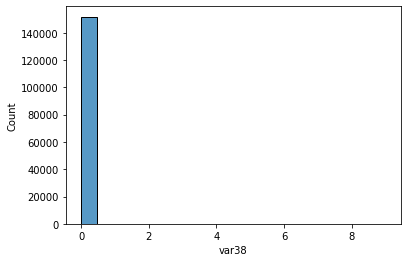

In [407]:
sns.histplot(data=df['var38'])

In [408]:
for var in df.columns:
  if df[var].value_counts(ascending=False)[0]>140000: #too many Rare labels 
    df.drop(var,axis=1,inplace=True)

In [409]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151838 entries, 0 to 151837
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   var15                     151838 non-null  float64
 1   ind_var5_0                151838 non-null  float64
 2   ind_var5                  151838 non-null  float64
 3   ind_var30_0               151838 non-null  float64
 4   ind_var30                 151838 non-null  float64
 5   ind_var39_0               151838 non-null  float64
 6   ind_var41_0               151838 non-null  float64
 7   num_var4                  151838 non-null  float64
 8   num_var5_0                151838 non-null  float64
 9   num_var5                  151838 non-null  float64
 10  num_var35                 151838 non-null  float64
 11  num_var42                 151838 non-null  float64
 12  var36                     151838 non-null  float64
 13  ind_var10_ult1            151838 non-null  f

KeyboardInterrupt: ignored

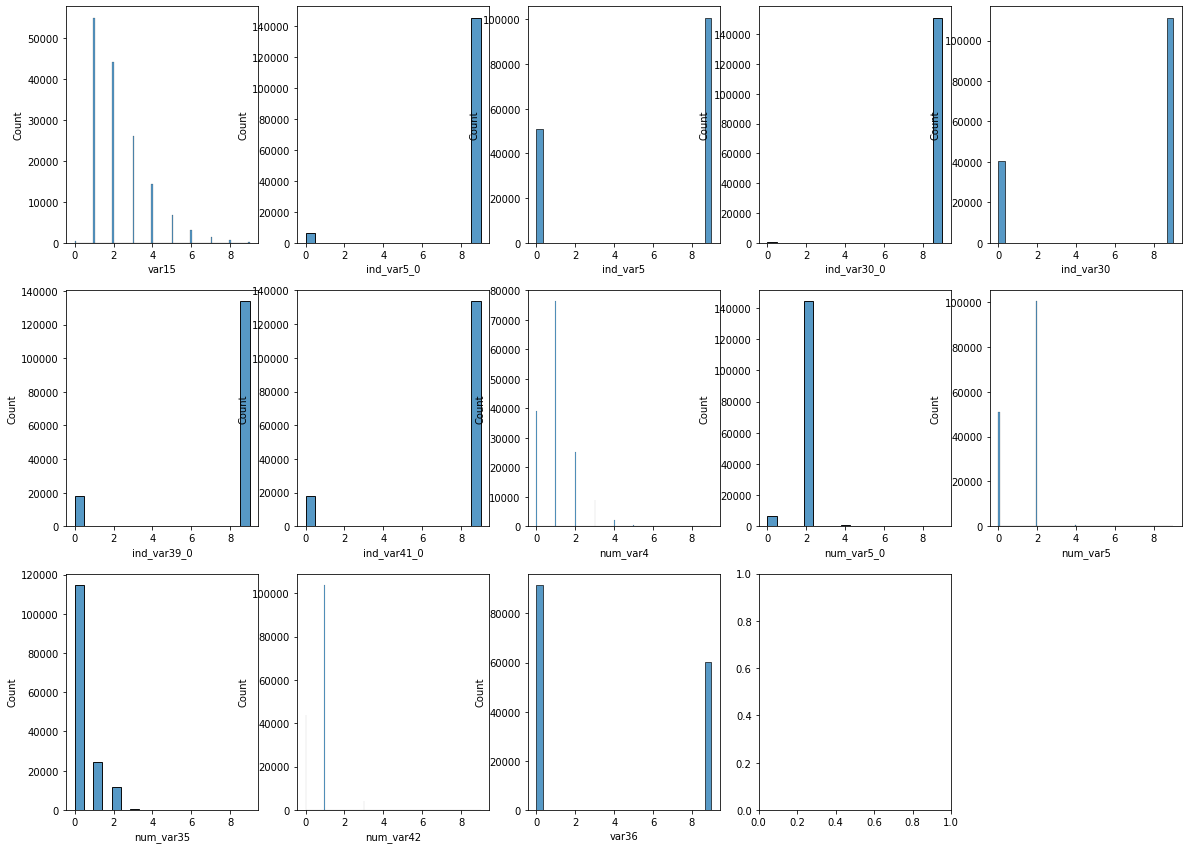

In [410]:
fig=plt.figure(figsize=(20,20))
for i,var in enumerate(df.columns):
  fig.add_subplot(4,5,i+1)
  sns.histplot(data=df[var])
plt.tight_layout

##4) Feature selection

In [ ]:
target_df.value_counts()

In [ ]:
selector=SelectKBest(chi2,k=10)
best10=selector.fit_transform(df.head(76020),target_df['TARGET'].dropna())
name=df.columns[selector.get_support()]
df=pd.DataFrame(best10,columns=name)

In [ ]:
df.info()

#3.Modeling

In [ ]:
realdf=pd.concat([df,target_df],axis=1)
santander_df=realdf.loc[realdf.TARGET!=2.0]
test_df=realdf.loc[realdf.TARGET==2.0].drop('TARGET',axis=1,inplace=True)
santander_target=santander_df['TARGET']
santander_feature=santander_df.drop('TARGET',axis=1)

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(santander_feature,santander_target,test_size=0.2,random_state=0)
xgb_clf=XGBClassifier(random_state=0)
lgbm_clf=LGBMClassifier(random_state=0)

In [ ]:
params={'learning_rate':[0.02],
        'n_estimators':[200,300,400],
        'max_depth':[3,5,7],
        'colsample_bytree':[0.7,0.8],
        'subsample':[0.9]}
xgb_gridcv=GridSearchCV(xgb_clf,param_grid=params,cv=5)
xgb_gridcv.fit(X_train,y_train)
print('Best parameters are\n',xgb_gridcv.best_params_)        

In [ ]:
params={'learning_rate':[0.02],
        'n_estimators':[200,300,400],
        'max_depth':[5,7,9],
        'colsample_bytree':[0.7,0.8],
        'subsample':[0.9]}
lgbm_gridcv=GridSearchCV(lgbm_clf,param_grid=params,cv=5)
lgbm_gridcv.fit(X_train,y_train)
print('Best parameters are\n',lgbm_gridcv.best_params_)        

In [ ]:
xgb_clf=xgb_gridcv.best_estimator_
lgbm_clf=lgbm_gridcv.best_estimator_
pred1=lgbm_clf.fit(X_train,y_train).predict(X_test)
pred2=xgb_clf.fit(X_train,y_train).predict(X_test)
vo_clf=VotingClassifier([('xgb',xgb_clf),('lgbm',lgbm_clf)],voting='soft',weights=[1,1])
pred=vo_clf.fit(X_train,y_train).predict(X_test)
print('Each score was : {0:4f} / {1:4f}'.format(roc_auc_score(y_test,pred1),roc_auc_score(y_test,pred2)))
print('\nfinal score was : ',roc_auc_score(y_test,pred))

#Uploading

In [ ]:
id=test_df['ID']
test_df.drop('ID',axis=1,inplace=True)
test_df.head(3)

In [ ]:
realpred=vo_clf.predict(test_df)
realpred=pd.DataFrame(realpred,columns=['TARGET'])
submit_df=pd.DataFrame({'ID':id,'TARGET':realpred})
submit_df.head(3)

In [ ]:
submit_df.to_csv('/content/gdrive/Mydrive/Dataset/Lutris_santander.csv',index=False)

#1) Feedback

#2) Afterwords